In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("F:\dataset_for_ML\supervised\chatGptGenerated\synthetic_classification_dataset.csv")

In [4]:
df.head()

,Age,Income,Education,Gender,Married,LoanAmount,Approved
0,39.0,51964.122914,High School,Male,No,15419.404257,1
1,33.0,48717.835422,Bachelor,Female,Yes,10546.661414,1
2,41.0,69035.815120,High School,Male,Yes,10820.259366,0
3,50.0,80656.622829,Master,Male,No,15669.075613,0
4,32.0,63736.938883,High School,Other,Yes,10775.234705,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         48456 non-null  float64
 1   Income      48453 non-null  float64
 2   Education   51000 non-null  object 
 3   Gender      51000 non-null  object 
 4   Married     51000 non-null  object 
 5   LoanAmount  48442 non-null  float64
 6   Approved    51000 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 2.7+ MB


In [6]:
df.duplicated().sum()

1009

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.duplicated().sum()

0

In [11]:
df.isna().sum()

Age           2501
Income        2486
Education        0
Gender           0
Married          0
LoanAmount    2486
Approved         0
dtype: int64

In [12]:
df.select_dtypes(["int","float"]).describe()

,Age,Income,LoanAmount,Approved
count,47490.000000,47505.000000,47505.000000,49991.000000
mean,34.496231,50924.853713,15118.574106,0.403033
std,9.993407,29275.128700,5849.097896,0.490512
min,-9.000000,-39259.370542,-7069.429832,0.000000
25%,28.000000,36621.766220,11628.537864,0.000000
50%,35.000000,50133.375764,14986.491841,0.000000
75%,41.000000,63677.115951,18375.040439,1.000000
max,79.000000,888255.728665,133532.596376,1.000000


Age
Income
LoanAmount
Approved


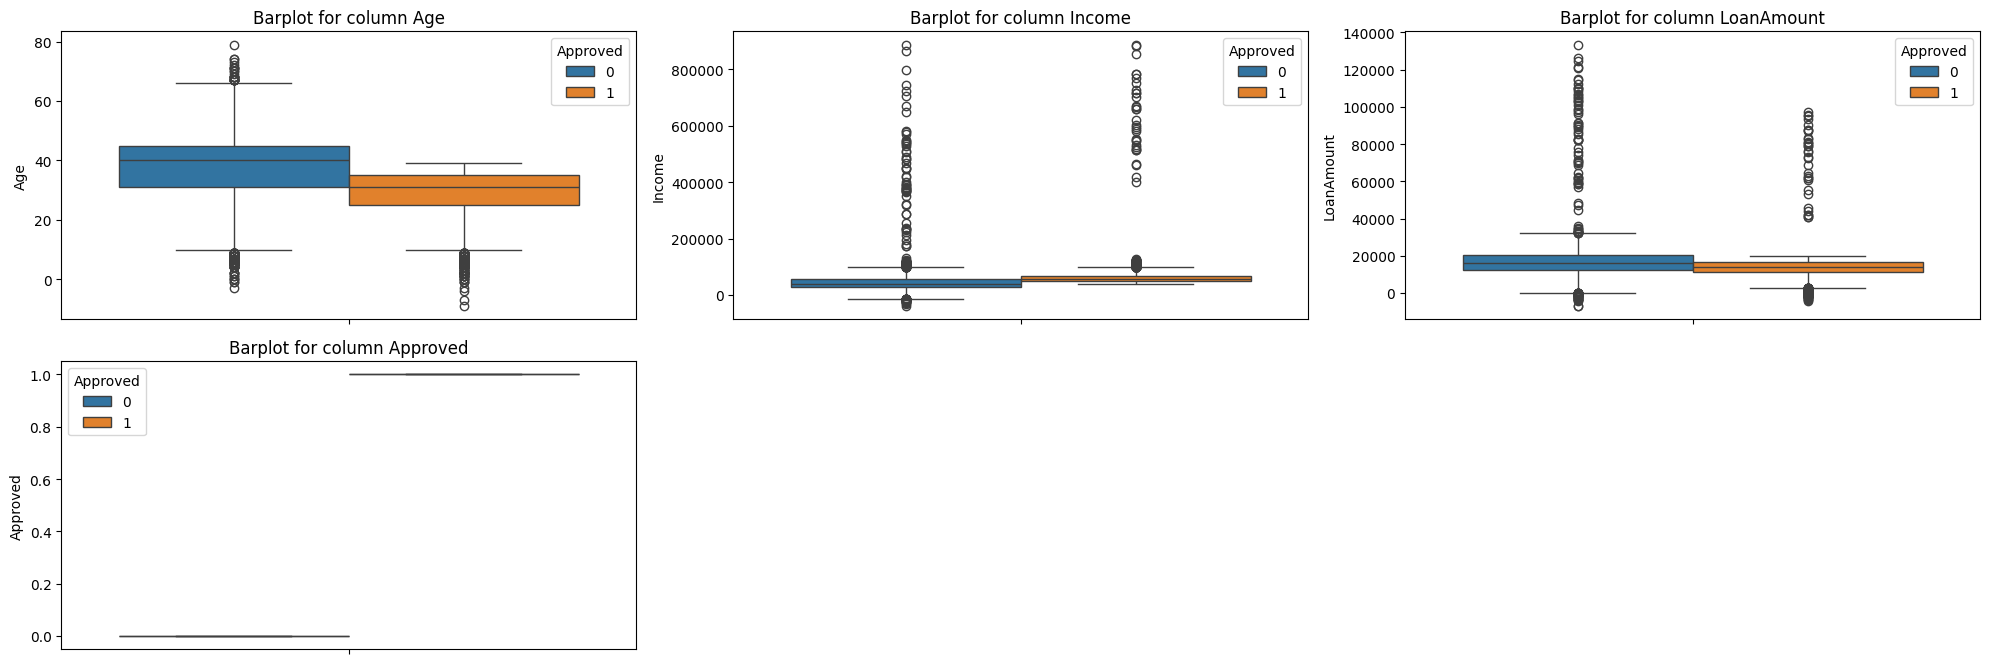

In [23]:
def boxplotFunction(df,for_hue):
    plt.figure(figsize=(20,10))
    for i,column in enumerate(df.columns,1):
        print(column)
        
        plt.subplot(3,3,i)
        sns.boxplot(data=df,y=column,hue=for_hue)
        plt.title(f'Barplot for column {column}')
    plt.tight_layout()
    plt.show()
       


boxplotFunction(df.select_dtypes(["int","float"]),df["Approved"])

Age
Income
LoanAmount
Approved


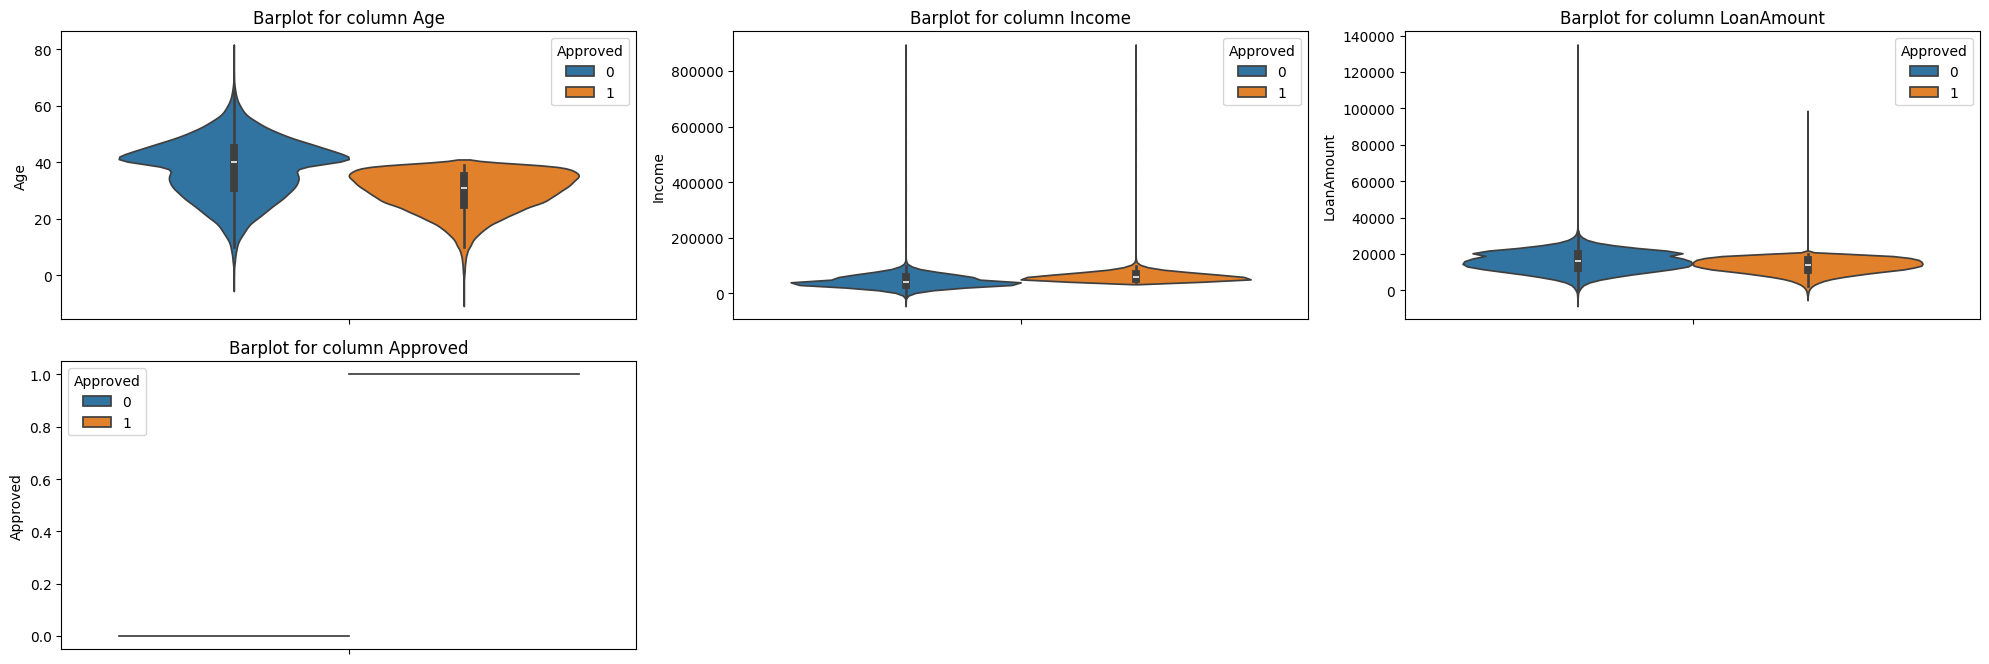

In [26]:
def violinplotFunction(df,for_hue):
    plt.figure(figsize=(20,10))
    for i,column in enumerate(df.columns,1):
        print(column)
        
        plt.subplot(3,3,i)
        sns.violinplot(data=df,y=column,hue=for_hue)
        plt.title(f'Barplot for column {column}')
    plt.tight_layout()
    plt.show()
       


violinplotFunction(df.select_dtypes(["int","float"]),df["Approved"])

Let's use z-index to remove the outliers 

In [41]:
def z_index_calc(df,threshold=3):
    temp_df = df.iloc[:,:-1]
    for column in temp_df:
        z_score = np.abs((temp_df[column]-temp_df[column].mean())/temp_df[column].std())
        print(z_score)

z_index_calc(df.select_dtypes(["int","float"]))

0        0.450674
1        0.149722
2        0.650806
3        1.551400
4        0.249788
           ...   
50007    1.450579
50185    0.650052
50206    0.350608
50495         NaN
50678    0.149722
Name: Age, Length: 49991, dtype: float64
0         0.035500
1         0.075389
2         0.618647
3         1.015598
4         0.437644
           ...    
50007    23.721170
50185    15.545121
50206    22.753408
50495    13.633792
50678    10.957180
Name: Income, Length: 49991, dtype: float64
0         0.051432
1         0.781644
2         0.734868
3         0.094117
4         0.742566
           ...    
50007    18.965302
50185    16.961247
50206    13.783696
50495    13.045069
50678    15.410029
Name: LoanAmount, Length: 49991, dtype: float64
